Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# *Dropout*
:label:`sec_dropout`

Em :numref:`sec_weight_decay`,
introduzimos a abordagem clássica
para regularizar modelos estatísticos
penalizando a norma $L_2$ dos pesos.
Em termos probabilísticos, poderíamos justificar esta técnica
argumentando que assumimos uma crença anterior
que os pesos tomam valores de
uma distribuição gaussiana com média zero.
Mais intuitivamente, podemos argumentar
que encorajamos o modelo a espalhar seus pesos
entre muitas características, em vez de depender demais
em um pequeno número de associações potencialmente espúrias.

## *Overfitting* Revisitado


Diante de mais características do que exemplos,
modelos lineares tendem a fazer *overfitting*.
Mas dados mais exemplos do que características,
geralmente podemos contar com modelos lineares para não ajustar demais.
Infelizmente, a confiabilidade com a qual
os modelos lineares generalizam têm um custo.
Aplicados ingenuamente, os modelos lineares não levam
em conta as interações entre as características.
Para cada recurso, um modelo linear deve atribuir
um peso positivo ou negativo, ignorando o contexto.

Em textos tradicionais, esta tensão fundamental
entre generalização e flexibilidade
é descrito como a *compensação de variação de polarização*.
Modelos lineares têm alta polarização: eles podem representar apenas uma pequena classe de funções.
No entanto, esses modelos têm baixa variação: eles fornecem resultados semelhantes
em diferentes amostras aleatórias dos dados.

Redes neurais profundas habitam o oposto
fim do espectro de polarização-variância.
Ao contrário dos modelos lineares, as redes neurais
não se limitam a examinar cada recurso individualmente.
Eles podem aprender interações entre grupos de recursos.
Por exemplo, eles podem inferir que
“Nigéria” e “Western Union” aparecendo
juntos em um e-mail indicam spam
mas separadamente eles não o fazem.


Mesmo quando temos muito mais exemplos do que características,
redes neurais profundas são capazes de fazer *overfitting*.
Em 2017, um grupo de pesquisadores demonstrou
a extrema flexibilidade das redes neurais
treinando redes profundas em imagens rotuladas aleatoriamente.
Apesar da ausência de qualquer padrão verdadeiro
ligando as entradas às saídas,
eles descobriram que a rede neural otimizada pelo gradiente descendente estocástico
poderia rotular todas as imagens no conjunto de treinamento perfeitamente.
Considere o que isso significa.
Se os rótulos forem atribuídos uniformemente
aleatoriamente e há 10 classes,
então nenhum classificador pode fazer melhor
precisão de 10% nos dados de validação.
A lacuna de generalização aqui é de 90%.
Se nossos modelos são tão expressivos que
podem fazer tanto *overftitting*, então, quando deveríamos
esperar que eles não se ajustem demais?

Os fundamentos matemáticos para
as propriedades de generalização intrigantes
de redes profundas permanecem questões de pesquisa em aberto,
e encorajamos os leitores orientados teoricamente
para se aprofundar no assunto.
Por enquanto, nos voltamos para a investigação de
ferramentas práticas que tendem a
melhorar empiricamente a generalização de redes profundas.

## Robustez por Meio de Perturbações


Vamos pensar brevemente sobre o que nós
esperamos de um bom modelo preditivo.
Queremos que ele funcione bem com dados não vistos.
A teoria da generalização clássica
sugere que para fechar a lacuna entre
treinar e testar o desempenho,
devemos ter como objetivo um modelo simples.
A simplicidade pode vir na forma
de um pequeno número de dimensões.
Exploramos isso ao discutir as
funções de base monomial de modelos lineares
em :numref:`sec_model_selection`.
Além disso, como vimos ao discutir o *weight decay*
(regularização $L_2$) em :numref:`sec_weight_decay`,
a norma (inversa) dos parâmetros também
representa uma medida útil de simplicidade.
Outra noção útil de simplicidade é suavidade,
ou seja, que a função não deve ser sensível
a pequenas mudanças em suas entradas.
Por exemplo, quando classificamos imagens,
esperaríamos que adicionar algum ruído aleatório
aos pixels seja inofensivo.

Em 1995, Christopher Bishop formalizou
essa ideia quando ele provou que o treinamento com ruído de entrada
equivale à regularização de Tikhonov :cite:`Bishop.1995`.
Este trabalho traçou uma conexão matemática clara
entre o requisito de que uma função seja suave (e, portanto, simples),
e a exigência de que seja resiliente
a perturbações na entrada.

Então, em 2014, Srivastava et al. :cite:`Srivastava.Hinton.Krizhevsky.ea.2014`
desenvolveram uma ideia inteligente de como aplicar a ideia de Bishop
às camadas internas de uma rede também.
Ou seja, eles propuseram injetar ruído
em cada camada da rede
antes de calcular a camada subsequente durante o treinamento.
Eles perceberam que durante o treinamento
uma rede profunda com muitas camadas,
injetando ruído reforça suavidade apenas no mapeamento de entrada-saída.


A ideia deles, chamada *dropout*, envolve
injetar ruído durante a computação de
cada camada interna durante a propagação direta,
e se tornou uma técnica padrão
para treinar redes neurais.
O método é chamado *dropout* porque nós literalmente
*abandonamos[^1]* alguns neurônios durante o treinamento.
Ao longo do treinamento, em cada iteração,
*dropout* padrão consiste em zerar
alguma fração dos nós em cada camada
antes de calcular a camada subsequente.

[^1]: A tradução do termo *drop out* do inglês pode ser interpretada, neste contexto, como abandonar, mas durante o texto, optou-se por usar o termo em inglês.

Para ser claro, estamos impondo
nossa própria narrativa com o link para Bishop.
O artigo original em *dropout*
oferece intuição através de uma surpreendente
analogia com a reprodução sexual.
Os autores argumentam que o *overfitting* da rede neural
é caracterizado por um estado em que
cada camada depende de um específico
padrão de ativações na camada anterior,
chamando essa condição de *co-adaptação*.
A desistência, eles afirmam, acaba com a co-adaptação
assim como a reprodução sexual é argumentada para
quebrar genes co-adaptados.

O principal desafio é como injetar esse ruído.
Uma ideia é injetar o ruído de uma maneira *imparcial*
de modo que o valor esperado de cada camada --- enquanto fixa
os outros --- seja igual ao valor que teria o ruído ausente.

No trabalho de Bishop, ele adicionou ruído gaussiano
às entradas de um modelo linear.
A cada iteração de treinamento, ele adicionava ruído
amostrado a partir de uma distribuição com média zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ à entrada $\mathbf{x}$,
produzindo um ponto perturbado $\mathbf{x}' = \mathbf{x} + \epsilon$.
Na expectativa, $E[\mathbf{x}'] = \mathbf{x}$.

Na regularização de *dropout*  padrão,
um tira o *bias* de cada camada normalizando
pela fração de nós que foram retidos (não descartados).
Em outras palavras,
com *probabilidade de dropout* $p$,
cada ativação intermediária $h$ é substituída por
uma variável aleatória $h'$ como segue:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ com probabilidade } p \\
    \frac{h}{1-p} & \text{ caso contrário}
\end{cases}
\end{aligned}
$$

Por design, a esperança permanece inalterada, ou seja, $E[h'] = h$.

## *Dropout* na Prática

Lembre-se do MLP com uma camada oculta e 5 unidades ocultas
em :numref:`fig_mlp`.
Quando aplicamos o *dropout* a uma camada oculta,
zerando cada unidade oculta com probabilidade $p$,
o resultado pode ser visto como uma rede
contendo apenas um subconjunto dos neurônios originais.
Em :numref:`fig_dropout2`, $h_2$ e $h_5$ são removidos.
Consequentemente, o cálculo das saídas
não depende mais de $h_2$ ou $h_5$
e seus respectivos gradientes também desaparecem
ao executar retropropagação.
Desta forma, o cálculo da camada de saída
não pode ser excessivamente dependente de qualquer
um elemento de $h_1, \ldots, h_5$.

![MLP antes e depois do *dropout*.](../img/dropout2.svg)
:label:`fig_dropout2`

Normalmente, desabilitamos o *dropout* no momento do teste.
Dado um modelo treinado e um novo exemplo,
nós não eliminamos nenhum nó
e, portanto, não precisamos normalizar.
No entanto, existem algumas exceções:
alguns pesquisadores usam o *dropout* na hora do teste como uma heurística
para estimar a *incerteza* das previsões da rede neural:
se as previsões concordam em muitas máscaras de *dropout*,
então podemos dizer que a rede está mais confiável.

## Implementação do Zero

Para implementar a função *dropout* para uma única camada,
devemos tirar tantas amostras
de uma variável aleatória de Bernoulli (binária)
quanto o número de dimensões de nossa camada,
onde a variável aleatória assume o valor $1$ (*keep*)
com probabilidade $1-p$ e $0$ (*drop*) com probabilidade $p$.
Uma maneira fácil de implementar isso é primeiro desenhar amostras
da distribuição uniforme $U[0, 1]$.
Então, podemos manter os nós para os quais a amostra correspondente é maior do que $p$, descartando o resto.

No código a seguir, (**implementamos uma função `dropout_layer`
que elimina os elementos na entrada do tensor `X`
com probabilidade de `dropout`**),
redimensionando o restante conforme descrito acima:
dividindo os sobreviventes por `1.0-dropout`.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

Podemos [**testar a função `dropout_layer` em alguns exemplos**].
Nas seguintes linhas de código,
passamos nossa entrada `X` através da operação de *dropout*,
com probabilidades 0, 0,5 e 1, respectivamente.


In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  8.,  0.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Definindo os Parâmetros do Modelo

Mais uma vez, trabalhamos com o conjunto de dados Fashion-MNIST
introduzido em :numref:`sec_fashion_mnist`.
Nós [**definimos um MLP com
duas camadas ocultas contendo 256 unidades cada.**]


In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### Definindo o Modelo

O modelo abaixo aplica *dropout* à saída
de cada camada oculta (seguindo a função de ativação).
Podemos definir probabilidades de *dropout* para cada camada separadamente.
Uma tendência comum é definir
uma probabilidade de *dropout* mais baixa perto da camada de entrada.
Abaixo, nós o definimos como 0,2 e 0,5 para o primeiro
e segundas camadas ocultas, respectivamente.
Garantimos que o *dropout* seja ativo apenas durante o treinamento.


In [4]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### [**Treinamento e Teste**]

Isso é semelhante ao treinamento e teste de MLPs descritos anteriormente.


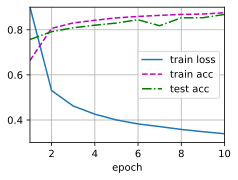

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## [**Implementação Concisa**]

Com APIs de alto nível, tudo o que precisamos fazer é adicionar uma camada `Dropout`
após cada camada totalmente conectada,
passando na probabilidade de *dropout*
como o único argumento para seu construtor.
Durante o treinamento, a camada `Dropout` irá aleatoriamente
eliminar as saídas da camada anterior
(ou de forma equivalente, as entradas para a camada subsequente)
de acordo com a probabilidade de abandono especificada.
Quando não estiver no modo de treinamento,
a camada `Dropout` simplesmente passa os dados durante o teste.


In [6]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

Em seguida, [**treinamos e testamos o modelo**].


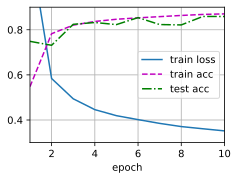

In [7]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Resumo

* Além de controlar o número de dimensões e o tamanho do vetor de peso, o *dropout* é outra ferramenta para evitar *overfitting*. Frequentemente, eles são usados em conjunto.
* *Dropout* substitui uma ativação $h$ por uma variável aleatória com valor esperado $h$.
* O *dropout* é usado apenas durante o treinamento.


## Exercícios

1. O que acontece se você alterar as probabilidades de *dropout* para a primeira e segunda camadas? Em particular, o que acontece se você trocar os de ambas as camadas? Projete um experimento para responder a essas perguntas, descreva seus resultados quantitativamente e resuma as conclusões qualitativas.
1. Aumente o número de épocas e compare os resultados obtidos ao usar *dropout* com os que não o usam.
1. Qual é a variação das ativações em cada camada oculta quando o *dropout* é e não é aplicado? Desenhe um gráfico para mostrar como essa quantidade evolui ao longo do tempo para ambos os modelos.
1. Por que o *dropout* normalmente não é usado no momento do teste?
1. Usando o modelo nesta seção como exemplo, compare os efeitos do uso de *dropout* e *weight decay*. O que acontece quando o *dropout* e *weight decay* são usados ​​ao mesmo tempo? Os resultados são cumulativos? Existem retornos diminuídos (ou pior)? Eles se cancelam?
1. O que acontece se aplicarmos o *dropout* aos pesos individuais da matriz de pesos em vez das ativações?
1. Invente outra técnica para injetar ruído aleatório em cada camada que seja diferente da técnica de *dropout* padrão. Você pode desenvolver um método que supere o *dropout* no conjunto de dados Fashion-MNIST (para uma arquitetura fixa)?


[Discussions](https://discuss.d2l.ai/t/101)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTg3NjU5ODEyNyw5NTczMjIxNTQsMTAzMT
Y2NjM3NywxMzYzNzk5Nzk2LDE3NzQyNDk0NDYsLTE4Mjg2MDg4
OTksMjYxNTA0MzY4LDY4NTA5NjgwOCwtMTczOTExODQxMCwxMz
gwMTc4NTUwLC05ODA4NzczNTddfQ==
-->
